# Regression and Classification with the Ames Housing Data

In [15]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Estimating the value of homes from fixed characteristics.

---

My superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then I can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

I have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. 
I need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything I deem can be modified without having to undergo major construction on the house.

---

**My goals:**
- Perform any cleaning, feature engineering, and EDA.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize my model. How well does it perform? What are the best estimates of price?

### Note: 
I have not included MiscFeature or MiscVal in my analysis becauase it's made up of both fixed and non-fixed features. I cannot be sure how much of the MiscVal is split between each feature, so this didn't feel appropriate to include. 

In [16]:
# Read in the data

house = pd.read_csv('/Users/gemmaboyle/Desktop/GA-DSI/resource_datasets/resource-datasets/project_3/housing.csv')

In [17]:
# Have a look at the data overall, where are the null values?

# house.info()

In [18]:
house.shape

(1460, 81)

In [19]:
# In order to remove non-residential housing call the unique identifiers for MSZoning

house.MSZoning.unique()


array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [20]:
# Remove non-residential properties from the data set (just C for commercial)

res_house = house[(house.MSZoning != 'C (all)')]
res_house.MSZoning.unique()


array(['RL', 'RM', 'FV', 'RH'], dtype=object)

In [21]:
# Look again at null values 
# res_house.info()

In [22]:
# Removing the rows with NaN values in LotFrontage, MasVnrType, Electric. Each of these columns either already 
# include a None value, therefore the NaN value is missing data (in the case of LotFrontage NaN is assumed to
# be missing data as a Lot cannot have 0 frontage. 

remove_na = res_house.dropna(axis=0, subset=['LotFrontage','MasVnrType','Electrical'])

In [23]:
# Now I want to convert the remaining NaN's to 'None' as in each of the columns where this exists it means 'None'
# For example in Alley NaN means there isn't one, this is the same for Garage Type, Fence etc. 

replace_na = remove_na.fillna(value='None',axis=1, inplace=False)

In [24]:
# Turn numerical categorical data to string types (object types)
# Exception: Overall quality and Overall condition. Despite being categorical (1-10) we can consider 
# this as a continuous variable as something like a quality rating of 7.5 does make sense (whereas 3.5 
# fireplaces does not)

# What also needs to be dummified from the non-fixed features? Add in here. 
numerical_categorical = ['MSSubClass','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath',
                         'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                         'MoSold']


replace_na[['MSSubClass','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath',
                         'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                         'MoSold']] = replace_na[['MSSubClass','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath',
                         'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                         'MoSold',]].astype(str)


replace_na['YrSold'] = pd.to_numeric(replace_na['YrSold'])

replace_na.shape

(1184, 81)

In [25]:
# Baseline 

replace_na['SalePrice'].mean()

181349.50760135136

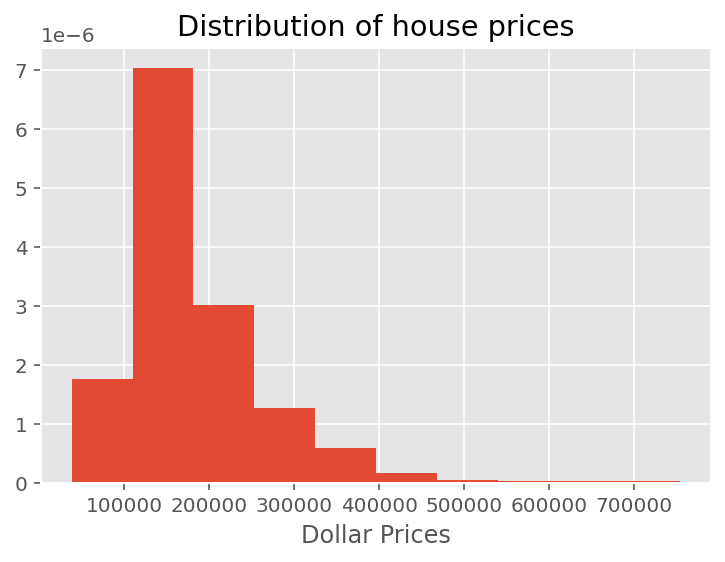

In [26]:
plt.hist(replace_na.SalePrice, density=True)
plt.title('Distribution of house prices')
plt.xlabel('Dollar Prices');
plt.savefig('Distribution_of_house_prices.png')

We can see the distribution of the Sale Price does not follow a normal distribution and is positively skewed. This suggests there will be several upper outliers. 

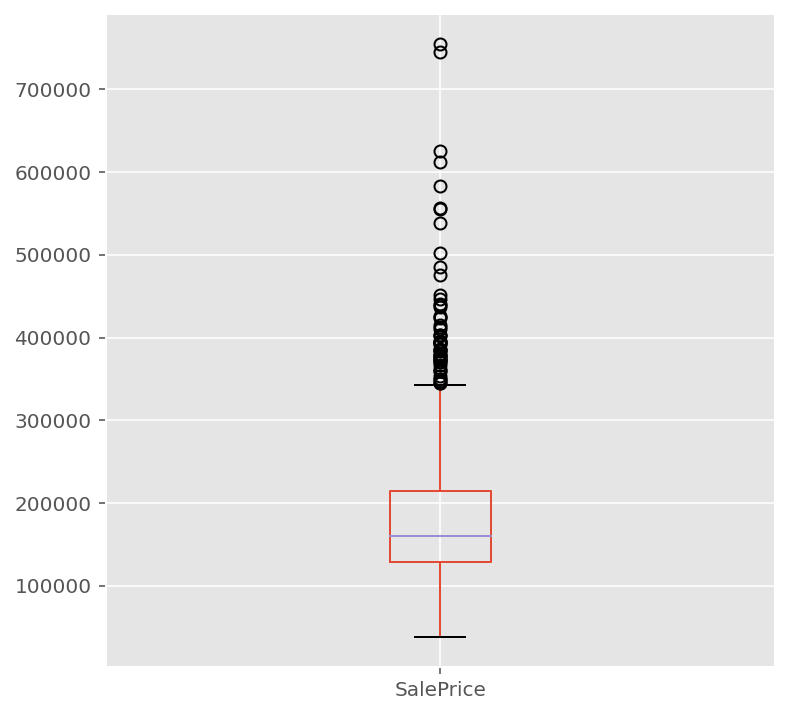

In [27]:
replace_na.boxplot(column = 'SalePrice', figsize=(6,6));
plt.savefig('Sale_price_boxplot.png')

There are many upper outliers in the data but there are two data points in particular exceptionally far outside 
the range of values. I originally ran my models with these data points included, but when I plotted the predicted 
values Vs the real sale values, these appeared outside the trend of data. However, when i removed them and re-ran
the models the mean CV score of each model actually decreased. Hence they have been included in the final models. 

In [28]:
# Dummify the data (all columns are now appropriate d-types except for Yr Sold, as I need to split on this)

house_dum = pd.get_dummies(replace_na)

In [29]:
house_test = house_dum[house_dum['YrSold'] == 2010]
house_train = house_dum[house_dum['YrSold'] != 2010]

In [30]:
# Split out the fixed and non_fixed features

# For fixed features I have chosen those indicators which would not require structural change to amend. 

fixed = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street', 'Alley','LotShape', 'LandContour',
        'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt',
        'MasVnrArea','Foundation','BsmtQual','TotalBsmtSF', '1stFlrSF','2ndFlrSF','GrLivArea','Fireplaces','GarageType', 
        'GarageYrBlt','GarageArea','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold',
        'YrSold','SaleType','SaleCondition' ,'Utilities','Functional','SalePrice']

# These column names have changed after dummifying, hence need a new list to collect these

fixed_dum = []

for i in fixed:
    for j in house_dum.columns:
        if i in j:
            fixed_dum.append(j)

house_test_fixed = house_test[fixed_dum]
house_train_fixed = house_train[fixed_dum]

print(house_test_fixed.shape)
print(house_train_fixed.shape)



(140, 373)
(1044, 373)


In [31]:
# Split out the non-fixed features into test and train (non 2010 and 2010) for later in the project 

# Non-fixed features have been chosen as those that do not require structural change to the property. 

non_fixed = ['OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
             'ExterQual','ExterCond','BsmtCond','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2',
             'BsmtUnfSF','Heating','HeatingQC','CentralAir','Electrical','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd',
             'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','WoodDeckSF','PoolQC','Fence',
             'Functional','BsmtExposure',"SalePrice"] 

non_fixed_dum = []

for i in non_fixed:
    for j in house_dum.columns:
        if i in j:
            non_fixed_dum.append(j)

house_test_non_fixed = house_test[non_fixed_dum]
house_train_non_fixed = house_train[non_fixed_dum]

print(house_test_non_fixed.shape)
print(house_train_non_fixed.shape)

(140, 199)
(1044, 199)


In [32]:
y_train = house_train_fixed.pop('SalePrice').values
x_train = house_train_fixed

y_test = house_test_fixed.pop('SalePrice').values
x_test = house_test_fixed

# Standardise the predictors
scaler = StandardScaler()

x_train_std = pd.DataFrame(scaler.fit_transform(x_train), 
                       columns=x_train.columns)

# Notice below we only have transform not fit transform, it's already stored the fit values for the variables 
x_test_std = pd.DataFrame(scaler.transform(x_test), 
                      columns=x_train.columns)

In [33]:
x_train_std.shape

(1044, 372)

In [34]:
# Train test split model fitter for data, used several times within the body of the project. 

def model_fitter(model, X_train, y_train, X_test, y_test, cv=5):
    model.fit(X_train, y_train)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
    print(cv_scores)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=cv))
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return 'Mean cv score = {}, training score = {}, test score = {}.'.format(cv_score, training_score, test_score)


## Basic Linear Regression Model

In [35]:
# Create a linear regression model instance

LRmodel = LinearRegression()

model_fitter(LRmodel, x_train_std, y_train, x_test_std, y_test)

[-6.64064529e+26 -8.00161300e+25 -1.09125836e+26 -4.99664235e+25
 -3.68589479e+26]


'Mean cv score = -2.543524794538489e+26, training score = 0.8836089332822846, test score = -3.4849063835330534e+24.'

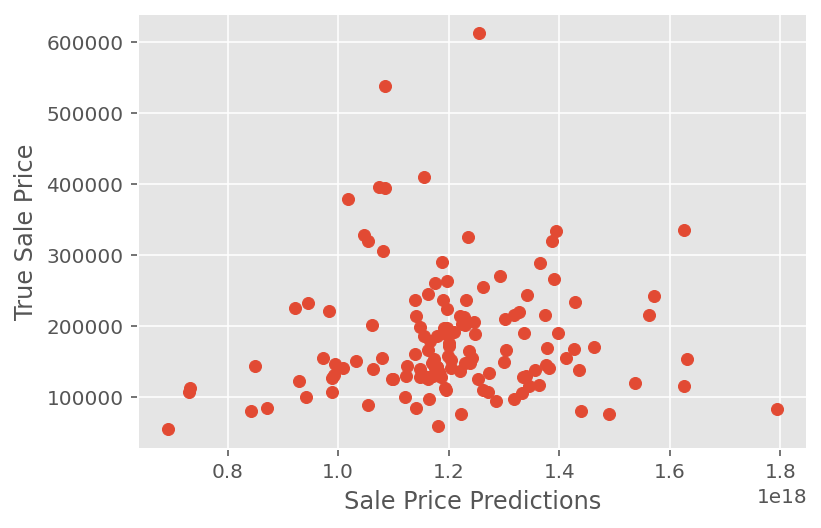

In [36]:
# The line / model
predictions_test = LRmodel.predict(x_test)
plt.scatter(predictions_test, y_test)
plt.xlabel("Sale Price Predictions")
plt.ylabel("True Sale Price")
plt.show()

### Analysis
The Linear regression model is very unsuitable for the given data. Most of the R squared values within the CV are negative with the training score being high and the test score also being negative, this suggests that the model is overfit and another model will be more suitable. The plot of predictions against actual values does not show good positive correlation. 

## Lasso Model 

In [37]:
# Find the best alpha (kept decreasing log space until I got a stable value)

model = LassoCV(alphas=np.logspace(3, 4, 10000))
model.fit(x_train_std, y_train)
model.alpha_

2413.449766361791

In [38]:
# Make the lasso model 

LSmodel = Lasso(alpha=2413.449766361791)

In [39]:
model_fitter(LSmodel, x_train_std, y_train, x_test_std, y_test, cv=10)

[0.87555066 0.86511554 0.82894039 0.73718689 0.73647743 0.75240304
 0.86031213 0.79387187 0.42525409 0.79352152]


'Mean cv score = 0.7668633542404983, training score = 0.8277772719813244, test score = 0.8494995777861584.'

In [40]:
LSmodel_coef = pd.DataFrame(list(zip(x_train_std.columns, LSmodel.coef_)))
LSmodel_coef.columns = ['Feature', 'Coef']
LSmodel_coef['Absolute Coef'] = LSmodel_coef.Coef.abs()
sorted_LScoef = LSmodel_coef.sort_values(by='Absolute Coef', ascending = False)
non_zero_coef = sorted_LScoef[sorted_LScoef.Coef != 0]
non_zero_coef.set_index('Feature', inplace=True)
print(non_zero_coef.shape)
non_zero_coef.head(15)

(48, 2)


,Coef,Absolute Coef
Feature,,
GrLivArea,27543.814383,27543.814383
BsmtQual_Ex,16622.681411,16622.681411
GarageArea,9626.486021,9626.486021
Neighborhood_NoRidge,8660.674399,8660.674399
Neighborhood_NridgHt,8433.910781,8433.910781
TotalBsmtSF,7027.755260,7027.755260
Neighborhood_StoneBr,6548.295233,6548.295233
Foundation_PConc,5052.544227,5052.544227
Fireplaces_2,4501.933375,4501.933375


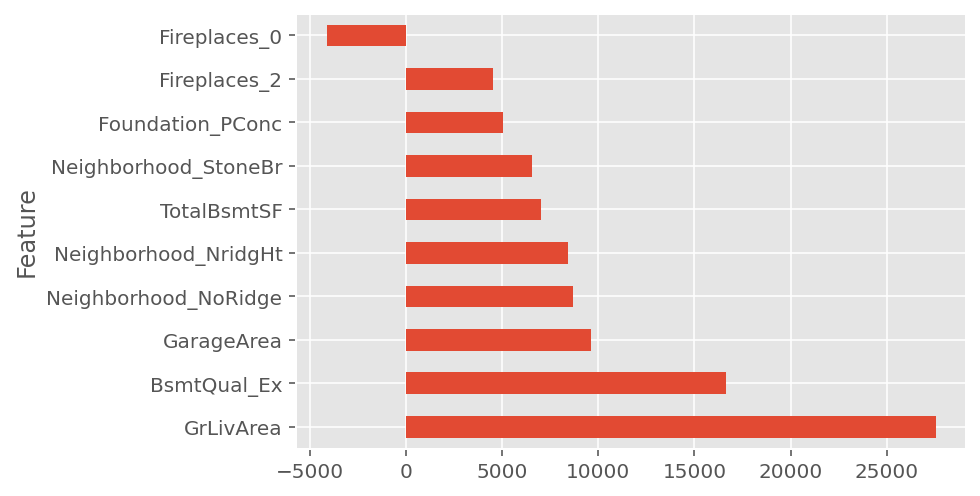

In [41]:
non_zero_coef.Coef.head(10).plot(kind='barh');

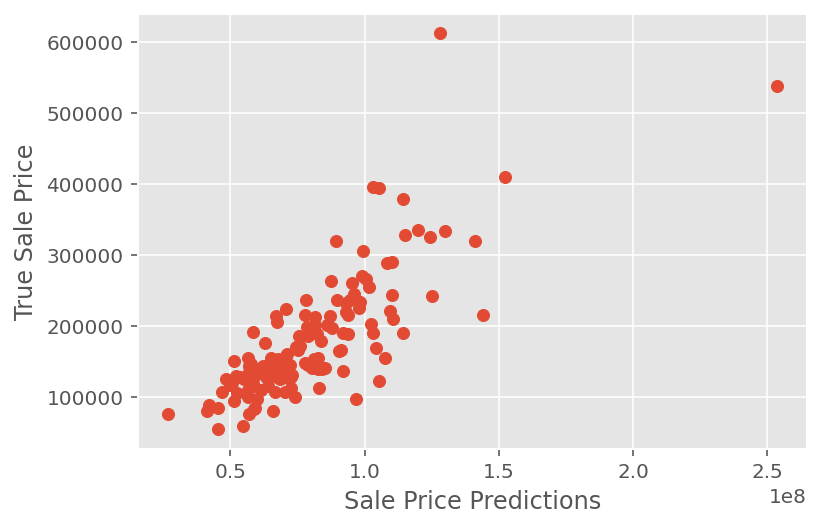

In [42]:
# The line / model
predictions_test = LSmodel.predict(x_test)
plt.scatter(predictions_test, y_test)
plt.xlabel("Sale Price Predictions")
plt.ylabel("True Sale Price")
plt.show()

### Lasso Analysis

Of the chosen fixed features most have 'zeroed out' on the Lasso model, leaving 48 features to contribute to the target variable of house price. Of these the features with the best positive impact are GrLivArea (Above grade (ground) living area square feet) and having an excellent basement, that is having a basement that exceeds 100 inches in height. The largest negative impacting feature is having a typical basement quality. 

This is unlikely to give the optimum solution as the mean CV score is significantly lower than the training score due to the impact of a low CV score in 1 of the K-Folds. 

The plot of sale predictions against the true sale price shows a positive correlation. 


## Ridge Model 

In [43]:
model = RidgeCV(alphas=np.logspace(2, 3, 10000))
model.fit(x_train_std, y_train)
model.alpha_

866.5503048444525

In [44]:
# Instantiate the Ridge model 
Rmodel = Ridge(alpha=866.5503048444525)

In [45]:
model_fitter(Rmodel, x_train_std, y_train, x_test_std, y_test, cv=10)

[0.88064021 0.81315646 0.8126398  0.72315241 0.70344484 0.76975769
 0.86036527 0.80213966 0.47005843 0.80331485]


'Mean cv score = 0.763866961932827, training score = 0.8377056085898797, test score = 0.8375615121564935.'

In [46]:
Rmodel_coef = pd.DataFrame(list(zip(x_train_std.columns, Rmodel.coef_)))
Rmodel_coef.columns = ['Feature', 'Coef']
Rmodel_coef['Absolute Coef'] = LSmodel_coef.Coef.abs()
sorted_Rcoef = Rmodel_coef.sort_values(by='Absolute Coef', ascending = False)
non_zero_coef = sorted_Rcoef[sorted_Rcoef.Coef != 0]
non_zero_coef.set_index('Feature', inplace=True)
non_zero_coef.head(15)

,Coef,Absolute Coef
Feature,,
GrLivArea,9434.970286,27543.814383
BsmtQual_Ex,8513.414483,16622.681411
GarageArea,6092.807449,9626.486021
Neighborhood_NoRidge,5865.375138,8660.674399
Neighborhood_NridgHt,5855.333699,8433.910781
TotalBsmtSF,6099.311929,7027.755260
Neighborhood_StoneBr,4755.623818,6548.295233
Foundation_PConc,2740.716636,5052.544227
Fireplaces_2,4608.770530,4501.933375


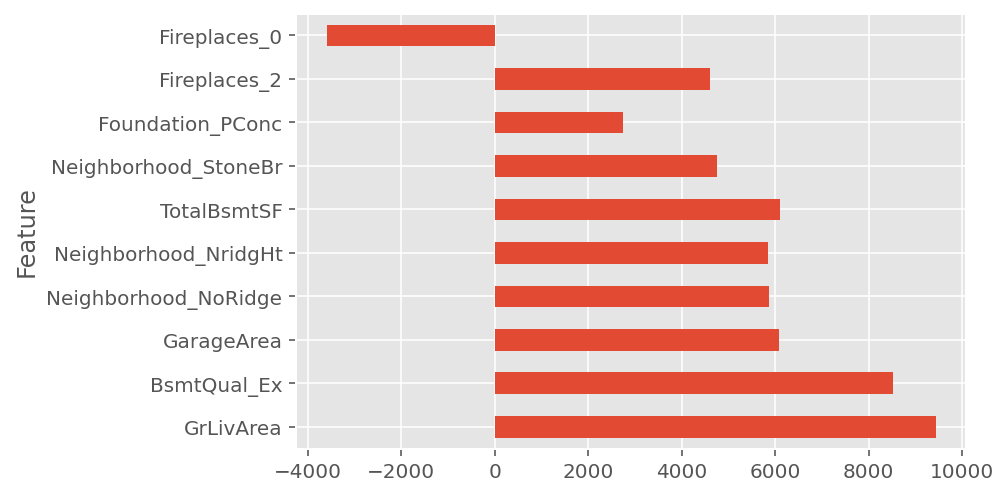

In [47]:
non_zero_coef.Coef.head(10).plot(kind='barh');

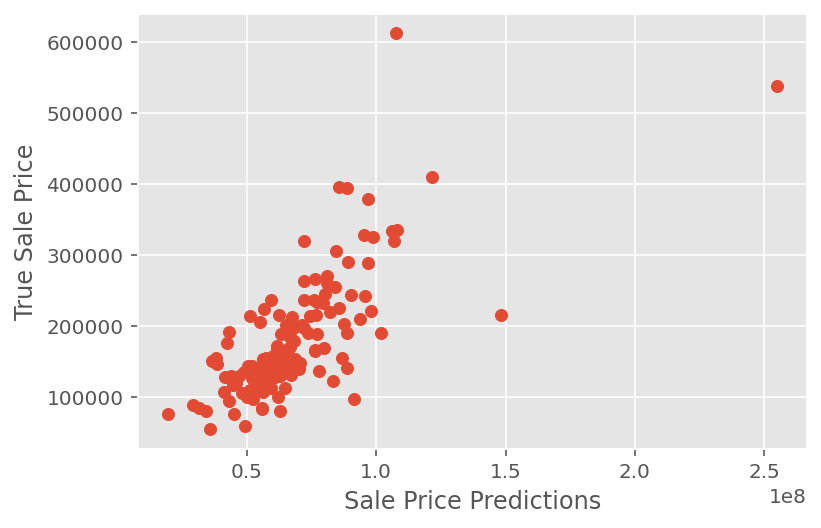

In [48]:
# The line / model
predictions_test = Rmodel.predict(x_test)
plt.scatter(predictions_test, y_test)
plt.xlabel("Sale Price Predictions")
plt.ylabel("True Sale Price")
plt.show()

### Ridge Analysis

The Ridge scores for the model were appropriate but not as high as the Lasso scores, suggesting co-linearity in the data. Lasso remains the most appropriate model. 

## Elastic Net Model

In [49]:
# Elastic Net 

ENmodel = ElasticNetCV(l1_ratio=[0.99,0.999,0.9999,0.99999, 1], 
                     alphas=np.logspace(2, 3, 1000))
ENmodel.fit(x_train_std, y_train)
print(ENmodel.alpha_)
print(ENmodel.l1_ratio_)

639.4488428556944
0.999


In [50]:
ENmodel = ElasticNet(alpha=639.4488428556944, l1_ratio=0.999)
model_fitter(ENmodel, x_train_std, y_train, x_test_std, y_test, cv=10)

[0.88179115 0.82670217 0.82399121 0.73701283 0.718813   0.77795628
 0.86667957 0.80721003 0.46020864 0.81161666]


'Mean cv score = 0.771198154814647, training score = 0.8329321625650852, test score = 0.8453467630500859.'

In [52]:
ENmodel_coef = pd.DataFrame(list(zip(x_train_std.columns, ENmodel.coef_)))
ENmodel_coef.columns = ['Feature', 'Coef']
ENmodel_coef['Absolute Coef'] = ENmodel_coef.Coef.abs()
sorted_ENcoef = ENmodel_coef.sort_values(by='Absolute Coef', ascending = False)
non_zero_coef = sorted_ENcoef[sorted_ENcoef.Coef != 0]
non_zero_coef.set_index('Feature', inplace=True)
non_zero_coef.head(15)

,Coef,Absolute Coef
Feature,,
GrLivArea,10646.503317,10646.503317
BsmtQual_Ex,9657.512172,9657.512172
1stFlrSF,7847.884308,7847.884308
GarageArea,6943.884247,6943.884247
TotalBsmtSF,6536.883169,6536.883169
Neighborhood_NridgHt,6379.326703,6379.326703
Neighborhood_NoRidge,6363.085862,6363.085862
2ndFlrSF,5269.207355,5269.207355
Neighborhood_StoneBr,5017.305934,5017.305934


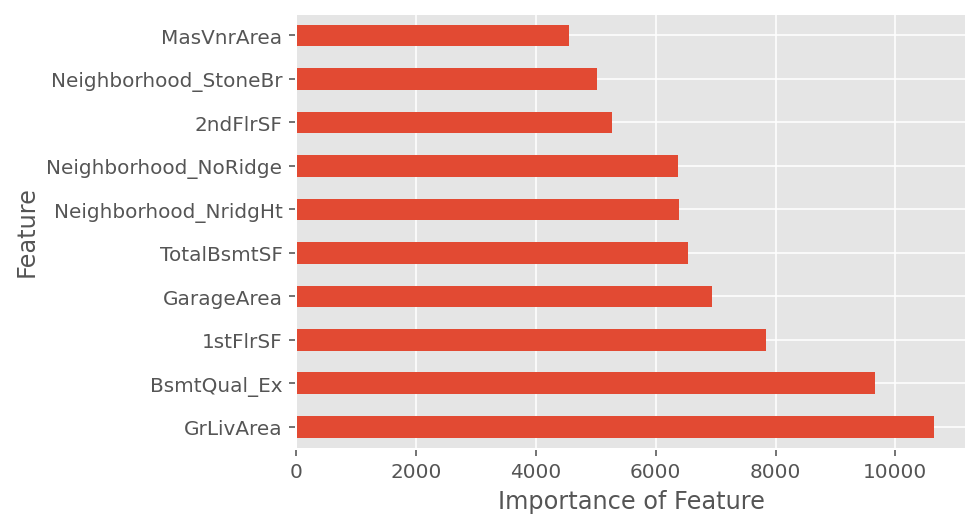

In [53]:
non_zero_coef.Coef.head(10).plot(kind='barh')
plt.xlabel('Importance of Feature');
plt.savefig('Feature Importance.png',bbox_inches='tight')

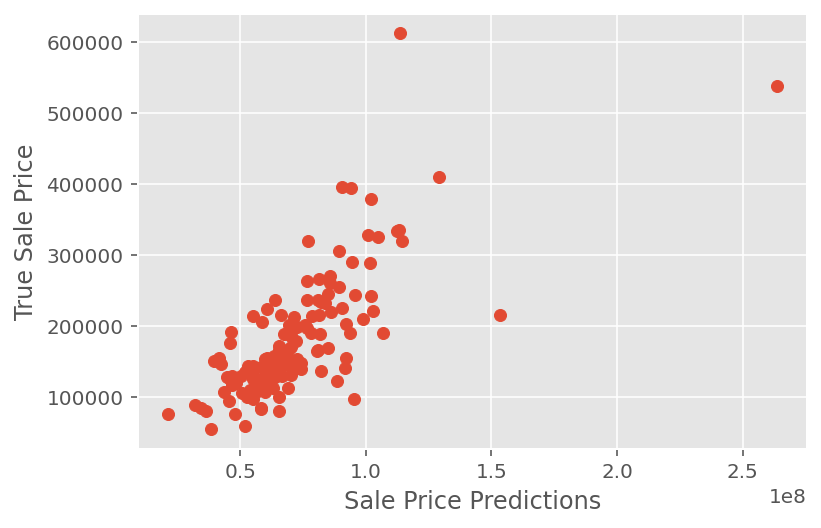

In [54]:
predictions_test = ENmodel.predict(x_test)
plt.scatter(predictions_test, y_test)
plt.xlabel("Sale Price Predictions")
plt.ylabel("True Sale Price");
plt.savefig('Predictions against true sale prices.png', bbox_inches='tight')

### Elastic Net Analysis

The Elastic net mean CV score is the highest of the four models, it ran very close to a full lasso model, but not completely, at an L1 ratio of 0.999. The true price Vs predictions plot shows excellent linear correlation baring a few exceptional outliers, which also appeared in the plots of other models. I did try to remove these and run the model again but this resulted in a lower mean CV value. 

Again the coefficients show that the above ground living area is the most important feature, adding close to £11,00 value to the house sale price, again a tall basement comes in a close 2nd. Unlike the other models there are no negatively correlated features in the top 15 features of the model. 

NOTE: I have declined to run a polynomial features model. The predictions Vs actual values plot shows good linear correlation and the training, test and mean CV values are such that the model already makes appropriate predictions, so a further polynomial analaysis is not necassary. 

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that I have a model that estimates the price of a house based on its static characteristics, I can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects will be in terms of dollars added or subtracted from the house value. 
2. The effects will be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Note
To begin I intend to run the model again with all features to see the dollar changes to the Sale Price based on the featues in the non_fixed set. I'm not sure this is necassary within the project but have left it in regardless. 

In [101]:
x2_train = house_train_non_fixed

In [102]:
y2_train = house_train_non_fixed.pop('SalePrice')

In [103]:
x2_train.shape

(1044, 198)

In [104]:
y2_test = house_test_non_fixed.pop('SalePrice')

In [105]:
x2_test = house_test_non_fixed

In [106]:
# Standardise the predictors (note, the data is already dummified from part 1)
scaler = StandardScaler()

x2_train_std = pd.DataFrame(scaler.fit_transform(x2_train), 
                       columns=x2_train.columns)

# Notice below we only have transform not fit transform, it's already stored the fit values for the variables 
x2_test_std = pd.DataFrame(scaler.transform(x2_test), 
                      columns=x2_test.columns)

In [107]:
# create a linear regression model instance

LR2model = LinearRegression()

model_fitter(LR2model, x2_train_std, y2_train, x2_test_std, y2_test, cv =10)

[ 8.83052831e-01 -5.35719373e+26 -1.22392574e+25 -1.63707770e+26
 -9.60055875e+25 -3.57792074e+24 -2.04242899e+25 -2.87580155e+26
 -1.72589924e+26 -1.01930442e+26]


'Mean cv score = -1.3937747198490171e+26, training score = 0.8758589277857238, test score = -8.80374844755722e+23.'

In [108]:
# Find the best alpha (kept decreasing log space until I got a stable value)

model = LassoCV(alphas=np.logspace(3, 4, 10000))
model.fit(x2_train_std, y2_train)
model.alpha_

1518.5116977131504

In [109]:
LS2model = Lasso(alpha=1518.5116977131504)
model_fitter(LS2model, x2_train_std, y2_train, x2_test_std, y2_test, cv=10)

[0.86335628 0.78127399 0.8679368  0.65012611 0.82680637 0.82371893
 0.84106942 0.76884402 0.55151981 0.79484363]


'Mean cv score = 0.7769495356013619, training score = 0.8502964151463017, test score = 0.8610666258556552.'

In [110]:
model = RidgeCV(alphas=np.logspace(2,3, 10000))
model.fit(x2_train_std, y2_train)
model.alpha_

399.908095683869

In [111]:
R2model = Ridge(alpha=399.908095683869)
model_fitter(R2model,x2_train_std, y2_train, x2_test_std, y2_test, cv=10)

[0.88143248 0.77928976 0.85324633 0.70168479 0.79963838 0.81025813
 0.8326681  0.75890409 0.55498457 0.81167016]


'Mean cv score = 0.7783776782444731, training score = 0.8506962354256526, test score = 0.8500338037078615.'

In [112]:
# Elastic Net 

EN2model = ElasticNetCV(l1_ratio=[0.99,0.999,0.9999,0.99999, 1], 
                     alphas=np.logspace(3, 4, 1000))
EN2model.fit(x2_train_std, y2_train)
print(EN2model.alpha_)
print(EN2model.l1_ratio_)

1132.5413151528114
0.9999


In [113]:
EN2model = ElasticNet(alpha=1132.5413151528114, l1_ratio=0.9999)
model_fitter(EN2model, x2_train_std, y2_train, x2_test_std, y2_test, cv=10)

[0.87695841 0.78150933 0.8605561  0.67618589 0.81789486 0.82153973
 0.84572064 0.77304936 0.57399933 0.8072874 ]


'Mean cv score = 0.7834701050073491, training score = 0.8508054364339197, test score = 0.8565021051237848.'

In [114]:
# Best model, get coefficients
EN2model_coef = pd.DataFrame(list(zip(x2_train_std.columns, EN2model.coef_)))
EN2model_coef.columns = ['Feature', 'Coef']
EN2model_coef['Absolute Coef'] = EN2model_coef.Coef.abs()
sorted_EN2coef = EN2model_coef.sort_values(by='Absolute Coef', ascending = False)
non_zero_coef = sorted_EN2coef[sorted_EN2coef.Coef != 0]
non_zero_coef.set_index('Feature', inplace=True)
non_zero_coef.head(15)




,Coef,Absolute Coef
Feature,,
OverallQual,19257.312885,19257.312885
BsmtFinSF1,13961.083180,13961.083180
RoofMatl_ClyTile,-9534.452933,9534.452933
FullBath_3,8806.524587,8806.524587
KitchenQual_Ex,8485.056200,8485.056200
TotRmsAbvGrd_10,7354.358842,7354.358842
BsmtUnfSF,6994.796471,6994.796471
FireplaceQu_None,-6396.215748,6396.215748
ExterQual_Ex,6344.618660,6344.618660


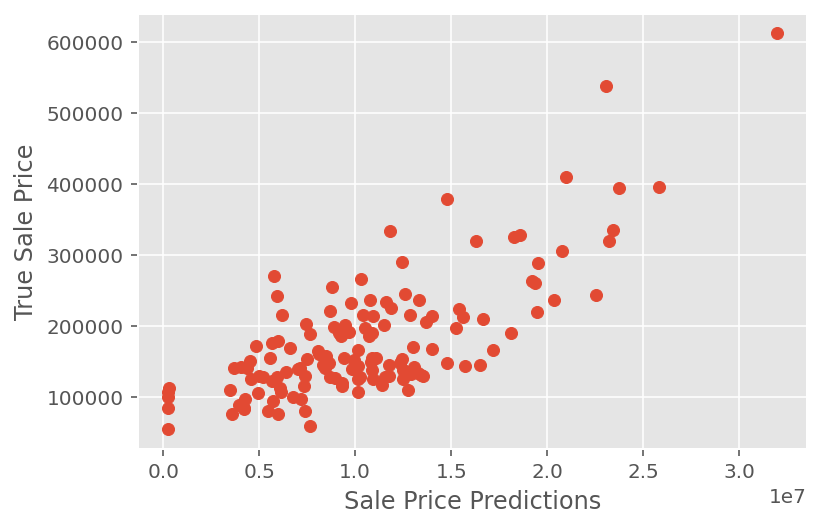

In [115]:
predictions_test = EN2model.predict(x2_test)
plt.scatter(predictions_test, y2_test)
plt.xlabel("Sale Price Predictions")
plt.ylabel("True Sale Price")
plt.show()

### Analysis 

Again the elastic net model comes out on top with a mean CV score of 0.7834, again it ran very close to a Lasso model with an L1_ratio of 0.999. The plot of predicted against true sale shows pleasing positive correlation with no obvious outliers. 

The coefficients from the model show the effect of these features on sale price (assuming all other features constant). The most important non-fixed feature for predicting house sale is the Overall Quality of the property, adding a whooping 19,000 dollars to house price for every 1 point increase in the quality metric. The largest negative contributer to the sale price was Clay tiles on the roof, removing clay tiles would add a value of almost 10,000 dollars(again with other features remaining constant). 

## Looking at residuals 
Note: When I first attempted to add in my y_train and y_test values (the actual prices of the houses for the train and test set) to my residuals data frame hundreds of NaN values popped up, despite there being none of these in the originl 'y' series (which I checked several times). I'm not sure why, but using y.values rather than y on it's own, managed to sort this issue. Once I ran the model a 2nd time the .values was no longer required, this is very confusing. 

In [58]:
y_train.shape

(1044,)

In [59]:
# Start by finding the residuals from the Elastic Net Model in part 1 (used due to it's largest mean CV score)

test_predict = ENmodel.predict(x_test_std)

test_residuals = pd.DataFrame(test_predict)

test_residuals.columns = ['Predictions']

test_residuals['Actual Values'] = y_test

test_residuals['Residuals'] = test_residuals['Actual Values'] - test_residuals['Predictions']

test_residuals

,Predictions,Actual Values,Residuals
0,124484.340907,134800,10315.659093
1,302126.911936,306000,3873.088064
2,181019.528686,165500,-15519.528686
3,118087.434279,109000,-9087.434279
4,277934.819118,319900,41965.180882
...,...,...,...
135,127429.246234,119000,-8429.246234
136,141309.919943,149700,8390.080057
137,212879.731914,210000,-2879.731914
138,214588.898294,266500,51911.101706


In [60]:
train_predict = ENmodel.predict(x_train_std)

train_residuals = pd.DataFrame(train_predict)

train_residuals.columns = ['Predictions']

train_residuals['Actual Values'] = y_train

train_residuals['Residuals'] = train_residuals['Actual Values'] - train_residuals['Predictions']

train_residuals

,Predictions,Actual Values,Residuals
0,194902.754514,208500,13597.245486
1,178294.043197,181500,3205.956803
2,212883.882086,223500,10616.117914
3,174818.460803,140000,-34818.460803
4,284877.550969,250000,-34877.550969
...,...,...,...
1039,134463.545360,145000,10536.454640
1040,144334.330135,84500,-59834.330135
1041,180474.684414,185000,4525.315586
1042,190048.387762,175000,-15048.387762


In [61]:
x3_train = house_train_non_fixed

y3_train = train_residuals['Residuals']

In [62]:
x3_test = house_test_non_fixed

y3_test = test_residuals['Residuals']


In [63]:
# Standardise the predictors

scaler = StandardScaler()

x3_train_std = pd.DataFrame(scaler.fit_transform(x3_train), 
                       columns=x3_train.columns)

# Notice below we only have transform not fit transform, it's already stored the fit values for the variables 
x3_test_std = pd.DataFrame(scaler.transform(x3_test), 
                      columns=x3_train.columns)

In [64]:
# Basic Linear Regression Model
L3model = LinearRegression()

model_fitter(L3model,x3_train_std, y3_train, x3_test_std, y3_test)

[-5.38162895e+26 -7.70680916e+26 -1.14758490e+26 -5.75126763e+25
 -4.20030492e+26]


'Mean cv score = -3.8022909392427745e+26, training score = 0.7858991073256155, test score = -5.745613238638226e+24.'

In [65]:
# Lasso Model

LS3model = LassoCV(alphas=np.logspace(3,6,1000))
LS3model.fit(x3_train_std, y3_train)
LS3model.alpha_

1000.0

In [66]:
LS3model = Lasso(alpha=2423.1727942376006)
model_fitter(LS3model, x3_train_std, y3_train, x3_test_std, y_test, cv=5)

[0.49745735 0.53352387 0.59614945 0.56124713 0.40131381]


'Mean cv score = 0.5179383217721218, training score = 0.6399510290446426, test score = -3.9472466893115543.'

In [67]:
LS3model_coef = pd.DataFrame(list(zip(x3_train_std.columns, LS3model.coef_)))
LS3model_coef.columns = ['Feature', 'Coef']
LS3model_coef['Absolute Coef'] = LS3model_coef.Coef.abs()
sorted_LS3coef = LS3model_coef.sort_values(by='Absolute Coef', ascending = False)
non_zero_coef = sorted_LS3coef[sorted_LS3coef.Coef != 0]
non_zero_coef.set_index('Feature', inplace=True)
non_zero_coef.head(15)

,Coef,Absolute Coef
Feature,,
SalePrice,23459.437982,23459.437982
RoofMatl_ClyTile,-8266.749626,8266.749626
FireplaceQu_None,4194.724283,4194.724283
OverallCond,3891.398085,3891.398085
BsmtUnfSF,-2904.278669,2904.278669
Exterior1st_VinylSd,-1674.483421,1674.483421
FullBath_2,-1588.437362,1588.437362
MasVnrType_None,937.612016,937.612016
GarageFinish_RFn,-758.233862,758.233862


In [68]:
# Elastic Net 

EN3model = ElasticNetCV(l1_ratio=[0.1,0.2,0.3,0.4,0.5,0.7,0.7,0.8,0.9,1], 
                     )
EN3model.fit(x3_train_std, y3_train)
print(EN3model.alpha_)
print(EN3model.l1_ratio_)

64.73984700753455
1.0


In [69]:
# Ridge Model 

R3model = RidgeCV(alphas=np.logspace(3,4, 10000))
R3model.fit(x3_train_std, y3_train)
R3model.alpha_

1000.0

In [70]:
R3model = Ridge(alpha=1785.7686009226109)
model_fitter(R3model, x3_train_std, y3_train, x3_test_std, y3_test)

[0.2823401  0.2368358  0.34239019 0.34370497 0.08923771]


'Mean cv score = 0.25890175107443236, training score = 0.4644026798595252, test score = 0.41897815352679957.'

In [71]:
R3model_coef = pd.DataFrame(list(zip(x3_train_std.columns, R3model.coef_)))
R3model_coef.columns = ['Feature', 'Coef']
R3model_coef['Absolute Coef'] = R3model_coef.Coef.abs()
sorted_R3coef = R3model_coef.sort_values(by='Absolute Coef', ascending = False)
non_zero_coef = sorted_R3coef[sorted_R3coef.Coef != 0]
non_zero_coef.set_index('Feature', inplace=True)
non_zero_coef.head(15)

,Coef,Absolute Coef
Feature,,
SalePrice,5501.471299,5501.471299
RoofMatl_ClyTile,-3751.326488,3751.326488
OverallCond,2098.654540,2098.654540
FullBath_3,1860.928841,1860.928841
RoofMatl_WdShngl,1837.153329,1837.153329
PoolQC_Gd,-1792.138668,1792.138668
PoolQC_Ex,1649.248042,1649.248042
KitchenQual_Ex,1561.304959,1561.304959
OverallQual,1485.679530,1485.679530


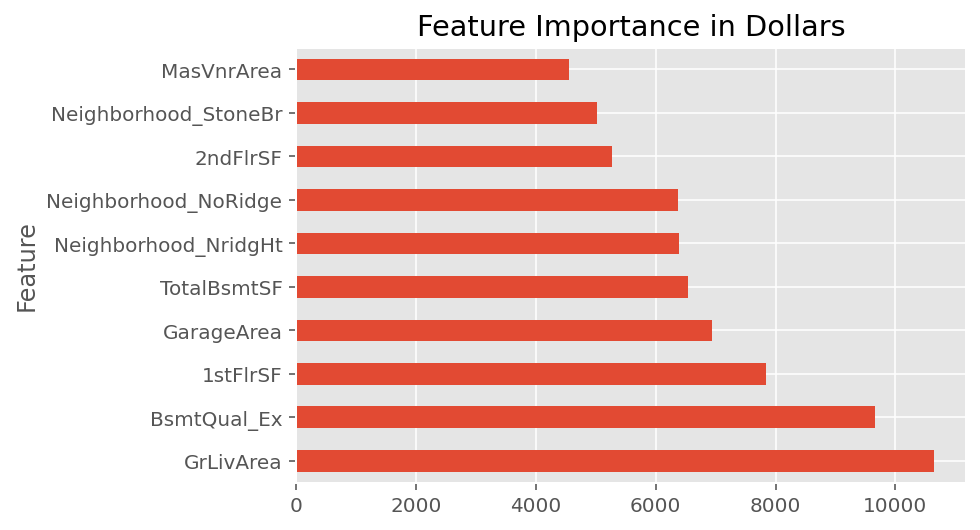

In [55]:
non_zero_coef.Coef.head(10).plot(kind='barh')
plt.title('Feature Importance in Dollars');
plt.savefig('Non fixed feature importance.png', bbox_inches='tight')

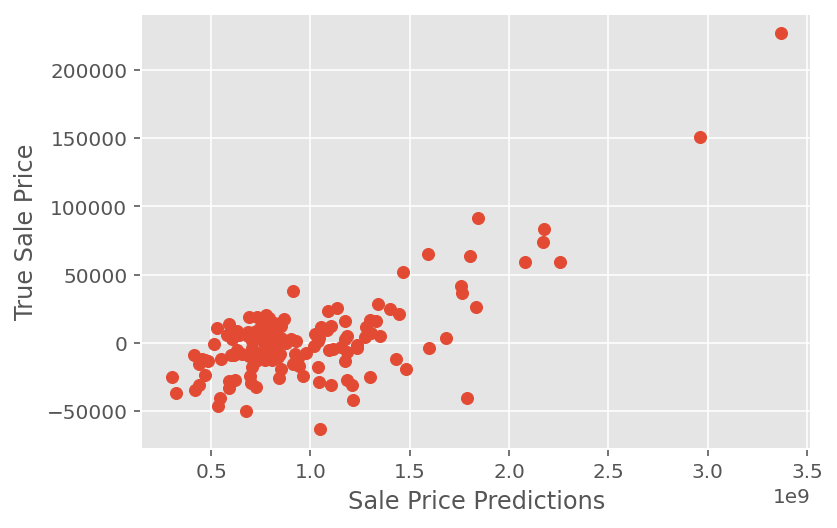

In [72]:
predictions_test = R3model.predict(x3_test)
plt.scatter(predictions_test, y3_test)
plt.xlabel("Sale Price Predictions")
plt.ylabel("True Sale Price");
plt.savefig('non fixed predictions against true.png', bbox_inches='tight')

This models looks like it might benefit from a quadratic polynomial features modelling. 

Your goals:

Evaluate the effect in dollars of the renovatable features.
How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.
Investigate how much of the variance in price remaining is explained by these features.
Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Residual Analysis

Although the Lasso model came out with the largest mean CV score it did not generalise well as seen by the negative R2 score on the test data. The Elastic Net ratio came out as 1, meaning a full Lasso model. The Ridge model had a slightly lower CV score than the Lasso but did generalise better, hence this is my preffered model. 

The largest contributer to the variance in residuals is clay tiles, this is a negative relationship meaning that removing clay tiles from a house can add almost 40000 to the sale price of the house, other features being fixed. The largerst positive contributer to the variance in residuals is full bath 3, meaning that having three above grade bathrooms contributes around 2200 to the house sale price. 



### Conclusions

The first model shows the main features the company should look for in a house for it to have a higher sale value, a large above groudn living area, a basement of large height, a large first floor area, a large garage area and a large basement area. As we can see these features are based on the size of the house, hence when buying property, bigger is better! It is important to note that the R2 squared value for the best model is around 0.75, meaning the model only accounts for around 75% of the varaince between actual and predicted prices. 

The second model is more tenuous, we can see from the best model run on the residuals from part 1 that even in the best case scenario only around 17% of the difference between actual and predicted price can be explained by recourse to the non-fixed features of the property, the rest being accounted for by the imperfectness of our model from part 1.
Hence I would not recommend buying houses in order to 'fix them up' and expect to do particularly well. However, where houses have already been purchased I would recommend removing clay tiles from the roof and replacing with wooden shinglts, increasing the quality of bathrooms and increasing the overall quality and condition of the property, as cheaply as possible, to add some value to the Sale Price

Construction and labour would be better served by building an extension / loft conversion in the house, where availble and where planning permission would be granted, in order to increase the overall living area of the property, as this is the largest indicator of sale price.

I would not be comfortable using the second model to choose which houses to buy and renovate, instead I would focus on buying larger properties.


## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives my your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked me with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

### Notes

For this part of the project I tried several methods, not all of which have been included below (due to lack of success). For each of these I have re-labelled all non-abnormal house sales as 'other' and attempted to predict the abnormal sales from this set. This leaves a significant class imbalance which I have attempted to address below. An overview of attempted methods that have not been included are below:

- Logistic regression with gridsearch optimised paramters for all features (not useful, mean CV score came out barely above the baseline, due to the class imbalance this baseline would be difficult to exceed!)

- KNN logisitic regression with gridsearch optimised parameters for all features 

- KNN logistic regression with gridsearch optimised parameters for the subset of features identified by the Lasso penalty logistic regression gridsearch (Mean CV Score lower than Lasso penalty model)

In [ ]:
replace_na.SaleCondition.unique()

In [ ]:
replace_na['SaleCondition'] = replace_na.SaleCondition.map(lambda x: x if x == 'Abnorml' else 'Other')
replace_na.SaleCondition.value_counts(normalize=True)

# The base rate for this would be 93% accuracy

In [ ]:
replace_na_classification = replace_na.drop(columns=['Id','SalePrice','MiscFeature'])

In [ ]:
replace_na.describe(include='all')

In [ ]:
# Eyeballing the features of abnormal sales

replace_na_classification[replace_na_classification['SaleCondition']=='Abnorml'].head()

### Note
I did originally run a classification model with all features, however even where the model guesses all the majority class the R2 score is very high due to the high baseline. Hence I read about dealing with class imbalance and the method for this is detailed below. 

In [ ]:
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### Dealing with class imbalance: Undersampling
Rationale: We have a large set of data, hence oversampling would increase this size so not appropriate.

Method: Take a random sample of 100 data rows of non-abnormal sales and use this along with all the abnormal sales to perform classification modelling on. 

Advantage = Undersampling evens out the imbalance between Abnormal and non-abnormal sales, getting around the issue of the program guessing the majority class and getting a high score. 

Drawback = The scores and validity of the model are dependent on the sample of non-abnormal sales. Even where random sampling is assured there can be large variance between samples, hence the score of the model fluctuates depending on the particular sample chosen, making the model less reliable.  

In [ ]:
df = replace_na_classification
abnormal_population = df[df['SaleCondition']=='Abnorml']
non_abnormal_sample = df[df['SaleCondition'] !='Abnorml'].sample(n=100)

### Note

If you run this model again the sample taken for the non_abnormal sales will change, hence the optimum parameters and scores will change, differing from the results below. 

In [ ]:
sale_type_df = non_abnormal_sample.append(abnormal_population)

In [ ]:
sale_type_df

In [ ]:
y = sale_type_df.pop('SaleCondition')

In [ ]:
y.value_counts(normalize=True).max()

# This is the new baseline for the model

In [ ]:
x = sale_type_df
x_dum = pd.get_dummies(sale_type_df)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_dum, y,
                        stratify=y, test_size=0.1, random_state=98)

In [ ]:
scaler = StandardScaler()
x_train_std = pd.DataFrame(scaler.fit_transform(x_train), 
                       columns=x_train.columns)

x_test_std = pd.DataFrame(scaler.transform(x_test), 
                      columns=x_train.columns)

In [ ]:
gs_params = {'penalty': ['l1', 'l2'],
              'solver': ['liblinear'],
              'C': np.logspace(-5, 5, 50)}

lr = LogisticRegression()

# create your gridsearch object
lr_gridsearch = GridSearchCV(lr,
                             gs_params,
                             n_jobs=2, 
                             cv=10, 
                             verbose=1)

lr_gridsearch.fit(x_train_std, y_train)

In [ ]:
lr_gridsearch.best_score_

In [ ]:
lr_gridsearch.best_params_

In [ ]:
opt_lr = LogisticRegression(C=0.19306977288832497, penalty= 'l1', solver= 'liblinear')
model_fitter(opt_lr, x_train_std, y_train, x_test_std, y_test, cv=10)

In [ ]:
Coef = pd.DataFrame(zip(x_train.columns, np.transpose(opt_lr.coef_)), columns=['features', 'coef']) 
Coef['Absolute Coef'] = Coef.coef.abs()
sorted_Coef = Coef.sort_values(by='Absolute Coef', ascending = False)
non_zero_coef = sorted_Coef[sorted_Coef.coef != 0]
print(non_zero_coef)
non_zero_coef_list = non_zero_coef.features.tolist()
non_zero_coef_list


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
x_dum[non_zero_coef_list]

In [ ]:
# In this part I have used the non-zero features identified from the model above to run a KNN classifer model. 

x2_dum = x_dum[non_zero_coef_list]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x2_dum, y,
                        stratify=y, test_size=0.1, random_state=98)

In [ ]:
scaler = StandardScaler()
x_train_std = pd.DataFrame(scaler.fit_transform(x_train), 
                       columns=x_train.columns)

x_test_std = pd.DataFrame(scaler.transform(x_test), 
                      columns=x_train.columns)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_parameters = {
    'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
    'weights':['uniform', 'distance'],
    'p':[1,2],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn = KNeighborsClassifier()

knn_gridsearcher = GridSearchCV(knn, knn_parameters, cv=4, verbose=1)
knn_gridsearcher.fit(x_train_std, y_train)

In [ ]:
knn_gridsearcher.best_score_

In [ ]:
knn_gridsearcher.best_params_

In [ ]:
opt_knn = KNeighborsClassifier(n_neighbors=2,weights='uniform', p=2, algorithm='ball_tree')
model_fitter(opt_knn, x_train_std, y_train, x_test_std, y_test, cv=5)

This mean CV score based on a KNN gridsearch using the features identified by the Lasso model above gave the best mean CV score of 0.72, well above the baseline of 0.56. However, these results must be taken with caution, as although there were positive CV and training score on the training data, the test score was marginally above the baseline, suggesting the model will not generalise well.  

In this case I would suggest the Ridge penalty logisitic regression model above is preferable as although the mean CV score was lower at 0.658, the training and test scores were more sensible, indicating that this model generalises better and would be a better future indicator of abnormal sales. However, the feature outcomes of this model make little sense, with a sale type COD (court officer deed) counting against the abnormal sales, and having an attached garage counting towards abnormal sales. 

I would suggest that predicting abnormal sales does not rely on the features of the house, instead it is perhaps more reasonable to assume that these sales are based on the features of the seller and thier personal financial situations rather than house properties. 

In [ ]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

# The following parts are based on the opt_knn above and were for me to practice methods. 

plot_confusion_matrix(opt_knn, x_train_std, y_train, cmap='Blues', values_format='.0f')
plt.grid(False)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(opt_knn, x_train_std, y_train, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(opt_knn, x_train_std, y_train, ax=ax)
plt.show()

## Class imbalance 

Severe class imbalance is an issue for many areas of data science machine learning (for example fraud detection or cancer cell detention). As well as the undersampling used within this project we may have also attempted to address the class imblance using other methods such as oversampling or the SMOTE algorithm. 